## Import

In [294]:
from sklearn.datasets import make_circles, make_moons, make_blobs
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import numpy as np
torch.manual_seed(42)

device="cuda" if torch.cuda.is_available() else "cpu"

## Define Training and Testing steps

In [295]:
def accuracy_fn(y_true,y_pred):
    #torch.eq calculates which elemnts in two tenors are equal
    correct=torch.eq(y_true,y_pred).sum().item()
    acc=(correct/len(y_pred)) *100
    return acc

In [296]:
def pass_NN(model:nn.Module,
            X=torch.Tensor,
            y=torch.Tensor):
    y_logits=model(X)
    num_classes=len(torch.unique(y))
    if num_classes>2:
        y_pred=y_logits.argmax(dim=1)
        loss_fn=nn.CrossEntropyLoss() #multiclass single label
        #combines LogSoftmax (logits -> log probs) and NLLLoss (penalises low prob for correct class)
        #takes in logits and outputs loss based on correct class probabilities
    else:
        y_logits=y_logits.squeeze() #squeeze to remove extra 1 dimension
        y_pred=torch.sigmoid(y_logits) #turn logits -> pred probs
        y_pred=torch.round(y_pred) #turn logits -> pred probs -> pred labels
        loss_fn=nn.BCEWithLogitsLoss() #binary classification

    loss=loss_fn(y_logits,y)
    acc=accuracy_fn(y_true=y,y_pred=y_pred)
    return loss,acc

In [297]:
def train_step(
        model:nn.Module,
        X_train:torch.Tensor,
        y_train:torch.Tensor,
        optimiser):
    model.train()
    train_loss,train_acc=pass_NN(model=model,X=X_train,y=y_train)
    #optimiser zero grad
    optimiser.zero_grad()
    #loss backwards
    train_loss.backward()
    #optimiser step
    optimiser.step()
    return train_loss, train_acc

In [298]:
def test_step(
        model:nn.Module,
        X_test:torch.Tensor,
        y_test:torch.Tensor):
    model.eval()
    with torch.inference_mode():
        test_loss,test_acc=pass_NN(model=model,X=X_test,y=y_test)
    return test_loss,test_acc

In [342]:
def train_model(
        model: nn.Module,
        X_train:torch.Tensor,
        y_train:torch.Tensor,
        X_test:torch.Tensor,
        y_test:torch.Tensor,
        epochs: int,
        lr: float,
        optimiser: torch.optim.Optimizer,
):
    train_losses,train_accs,test_accs,test_losses=[],[],[],[]
    #optimiser=torch.optim.Adam(params=model.parameters(),lr=1)
    optimiser = optimiser(lr=lr, params=model.parameters())
    for epoch in range(epochs):
        train_loss,train_acc=train_step(model=model,optimiser=optimiser,X_train=X_train, y_train=y_train)
        test_loss, test_acc = test_step(model=model,X_test=X_test, y_test=y_test)

        # Convert tensors to CPU before appending
        train_losses.append(train_loss.detach().cpu())
        train_accs.append(train_acc)  # train_acc is already a Python float
        test_losses.append(test_loss.detach().cpu())
        test_accs.append(test_acc)  # test_acc is already a Python float

        if epoch %  max(1, epochs // 10) == 0: #ensure don't divide by zero
            print(f"Epoch: {epoch} | Train Loss: {train_loss:.5f}, Train Accuracy: {train_acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
    return train_losses, train_accs, test_losses, test_accs
    

## Visualise

In [300]:
def plot_decision_boundary(
        model:nn.Module,
        X:torch.Tensor,
        y:torch.Tensor
):
        """Plots decision boundary of a model predicting on X in comparison to y"""
        #put everything to CPU as works better with numpy and matplotlib
        model.to('cpu')
        X,y=X.to('cpu'),y.to('cpu')

        #setup prediction boundaries
        x_min,x_max = X[:,0].min()-0.1, X[:,0].max()+0.1 
        y_min,y_max = X[:,1].min()-0.1, X[:,1].max()+0.1
        #0.1 padding on all sides for better visualisation, ensures boundaries encompass all data points

        #generate dense grid of points
        xx,yy=np.meshgrid(np.linspace(x_min,x_max,101), np.linspace(y_min,y_max,101))
        #np.linspace() creates 101 evenly spaced points between min and max
        #np.meshgrid() creates 2D grid from these points, resulting in 101x101 points covering entire feature space

        #make features - prepare grid points for prediction
        X_to_pred_on=torch.from_numpy(np.column_stack((xx.ravel(),yy.ravel()))).float()
        #.ravel() flattens 2D grid into 1D array, np.column_stack() combines them into (x,y) coord pairs
        #shape: (101*101, 2) = (10201, 2) = each row is an (x,y) point

        #make predictions
        model.eval()
        with torch.inference_mode():
                y_logits=model(X_to_pred_on)
        
        #if multi-class, use softmax, if binary, use sigmoid
        if len(torch.unique(y))>2:
                y_pred=torch.softmax(y_logits,dim=1).argmax(dim=1) #multi-class
        else:
                y_pred=torch.round(torch.sigmoid(y_logits)) #binary
        
        #reshape preds back to 101x101 grid shape
        y_pred=y_pred.reshape(xx.shape).detach().numpy()
        
        plt.contourf(xx,yy,y_pred,cmap=plt.cm.RdYlBu,alpha=0.7)
        #plt.contourf() creates filled contour regions, each region represents where model predicts specific class
        #alpha=0.7 makes background semi transparent

        plt.scatter(X[:,0],X[:,1],c=y,s=40,cmap=plt.cm.RdYlBu) #s=40 for medium sized dots
        #X[:,0] and X[:,1] are the two features (x and y coords respectively), c=y colours points by their true labels

        plt.xlim(xx.min(),xx.max())
        plt.ylim(yy.min(),yy.max())

In [301]:
def plot_predictions(
        train_data,train_labels,test_data,test_labels,predictions=None):
    plt.figure(figsize=(10, 7))

    #plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    #plot testing data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        #plot predictions in red - predictions made on test data
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
    
    #shows color coded legend with font size 14
    plt.legend(prop={"size": 14})

In [302]:
def visualise_predictions(
        model=nn.Module,
        X_train=torch.Tensor,
        X_test=torch.Tensor,
        y_train=torch.Tensor,
        y_test=torch.Tensor):
    # Plot decision boundaries for training and test sets
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Train")
    plot_decision_boundary(model, X_train, y_train)
    plt.subplot(1, 2, 2)
    plt.title("Test")
    plot_decision_boundary(model, X_test, y_test)

In [303]:
def plot_acc_losses(
    model_name: str,
    train_accs: list,
    test_accs: list,
    train_losses: list,
    test_losses: list,
    epochs: int = 7
):
    
    f,(ax1,ax2)=plt.subplots(1,2)
    f.set_size_inches(15,5)
    ax1.plot(np.arange(1,epochs+1,1),test_accs,label="Test Accuracies")
    ax1.plot(np.arange(1,epochs+1,1),train_accs, label="Train Accuracies")
    ax1.set_title(f"{model_name} Accuracies")
    ax1.legend()
    ax1.set_ylabel("Accuracies (%)")
    ax1.set_xlabel("Epochs")

    ax2.plot(np.arange(1,epochs+1,1),test_losses, label="Test Losses")
    ax2.plot(np.arange(1,epochs+1,1),train_losses, label="Train Losses")
    ax2.set_title(f"{model_name} Losses")
    ax2.legend()
    ax2.set_ylabel("Losses")
    ax2.set_xlabel("Epochs")
    

## Binary Classification

In [304]:
n_samples=1000
X,y=make_moons(n_samples,
                 noise=0.1, #add noise to data
                 random_state=42)

print(X.shape, y.shape)
#second dimension for X means that X has two features (2D data = vector) but y as single feature (1D data = scalar)
moons=pd.DataFrame({
    "X1":X[:,0],
    "X2":X[:,1],
    "label":y
})
print(f"Number of different labels: {moons.label.value_counts()}")
moons.head()

(1000, 2) (1000,)
Number of different labels: label
1    500
0    500
Name: count, dtype: int64


,X1,X2,label
0,-0.051470,0.444199,1
1,1.032017,-0.419741,1
2,0.867892,-0.254827,1
3,0.288851,-0.448669,1
4,-0.833439,0.535057,0


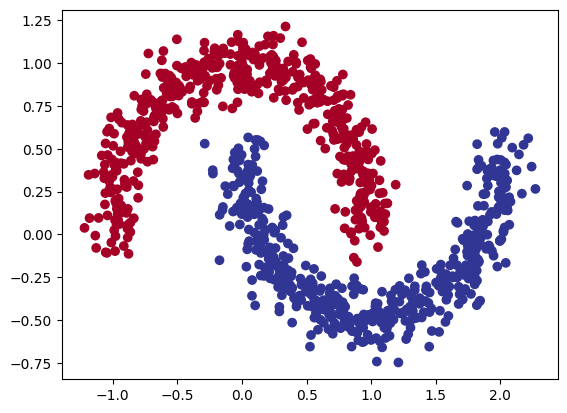

In [305]:
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [306]:
#turn data into tensors
(X_train,X_test,
 y_train,y_test)=train_test_split(torch.from_numpy(X).type(torch.float),
                                  torch.from_numpy(y).type(torch.float),
                                    test_size=0.2, #20% of data for testing
                                    random_state=42) #random split reproducible

X_train,y_train=X_train.to(device),y_train.to(device)
X_test,y_test=X_test.to(device),y_test.to(device)

### Evaluate Different Models

In [307]:
#model 0, a simple feedforward neural network with 5 hidden units and training with 100 epochs
model_0=nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)).to(device)

Epoch: 0 | Train Loss: 0.69398, Train Accuracy: 50.00% | Test loss: 0.68146, Test acc: 57.00%
Epoch: 10 | Train Loss: 0.57234, Train Accuracy: 80.00% | Test loss: 0.57371, Test acc: 77.00%
Epoch: 20 | Train Loss: 0.48831, Train Accuracy: 81.62% | Test loss: 0.49815, Test acc: 78.00%
Epoch: 30 | Train Loss: 0.42868, Train Accuracy: 82.12% | Test loss: 0.44397, Test acc: 79.50%
Epoch: 40 | Train Loss: 0.38794, Train Accuracy: 82.25% | Test loss: 0.40610, Test acc: 80.00%
Epoch: 50 | Train Loss: 0.36039, Train Accuracy: 83.12% | Test loss: 0.37953, Test acc: 81.50%
Epoch: 60 | Train Loss: 0.34129, Train Accuracy: 83.12% | Test loss: 0.36026, Test acc: 82.50%
Epoch: 70 | Train Loss: 0.32747, Train Accuracy: 83.62% | Test loss: 0.34563, Test acc: 83.00%
Epoch: 80 | Train Loss: 0.31695, Train Accuracy: 83.88% | Test loss: 0.33400, Test acc: 83.50%
Epoch: 90 | Train Loss: 0.30858, Train Accuracy: 84.62% | Test loss: 0.32438, Test acc: 83.50%


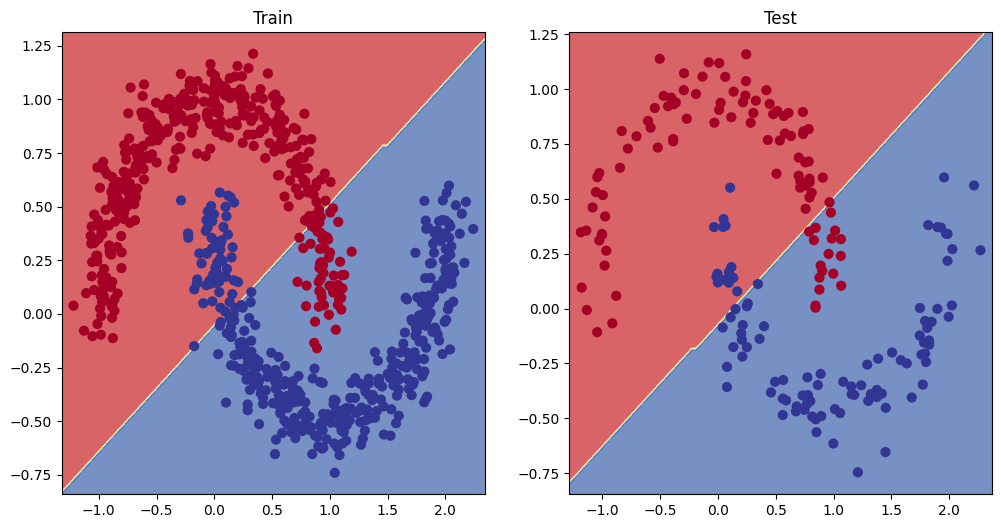

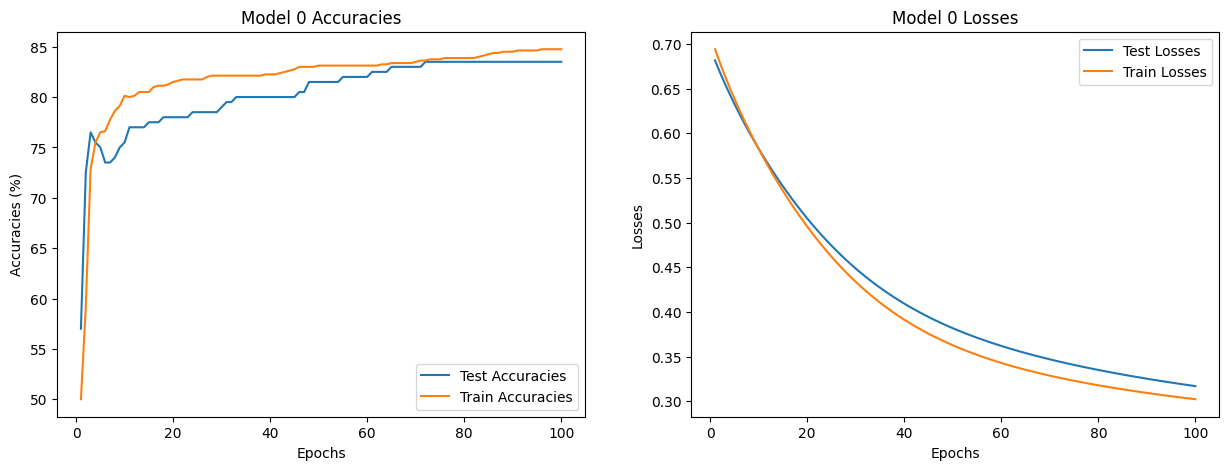

In [308]:
tr_losses_0,tr_accs_0,test_losses_0,test_accs_0=train_model(
    model=model_0,epochs=100,X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
visualise_predictions(model=model_0,X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
plot_acc_losses(model_name="Model 0", 
                train_accs=tr_accs_0, 
                test_accs=test_accs_0, 
                train_losses=tr_losses_0, 
                test_losses=test_losses_0, 
                epochs=100)

In [348]:
#add nonlinearity and adding more layers and training with many more epochs
model_1=nn.Sequential(
    nn.Linear(in_features=2, out_features=10),  
    nn.Tanh(),
    nn.Linear(in_features=10, out_features=10),  
    nn.Tanh(),
    nn.Linear(in_features=10, out_features=1)
).to(device)

Epoch: 0 | Train Loss: 0.71295, Train Accuracy: 50.00% | Test loss: 1.94261, Test acc: 36.50%
Epoch: 8 | Train Loss: 0.79191, Train Accuracy: 81.50% | Test loss: 0.44333, Test acc: 70.00%
Epoch: 16 | Train Loss: 0.50756, Train Accuracy: 85.12% | Test loss: 0.71401, Test acc: 81.00%
Epoch: 24 | Train Loss: 0.31744, Train Accuracy: 88.38% | Test loss: 0.18712, Test acc: 87.50%
Epoch: 32 | Train Loss: 0.15034, Train Accuracy: 95.00% | Test loss: 0.13962, Test acc: 95.00%
Epoch: 40 | Train Loss: 0.12228, Train Accuracy: 96.25% | Test loss: 0.11162, Test acc: 97.50%
Epoch: 48 | Train Loss: 0.08560, Train Accuracy: 97.75% | Test loss: 0.05611, Test acc: 99.50%
Epoch: 56 | Train Loss: 0.05958, Train Accuracy: 98.38% | Test loss: 0.01477, Test acc: 100.00%
Epoch: 64 | Train Loss: 0.03976, Train Accuracy: 99.00% | Test loss: 0.00752, Test acc: 100.00%
Epoch: 72 | Train Loss: 0.02430, Train Accuracy: 99.50% | Test loss: 0.00453, Test acc: 100.00%


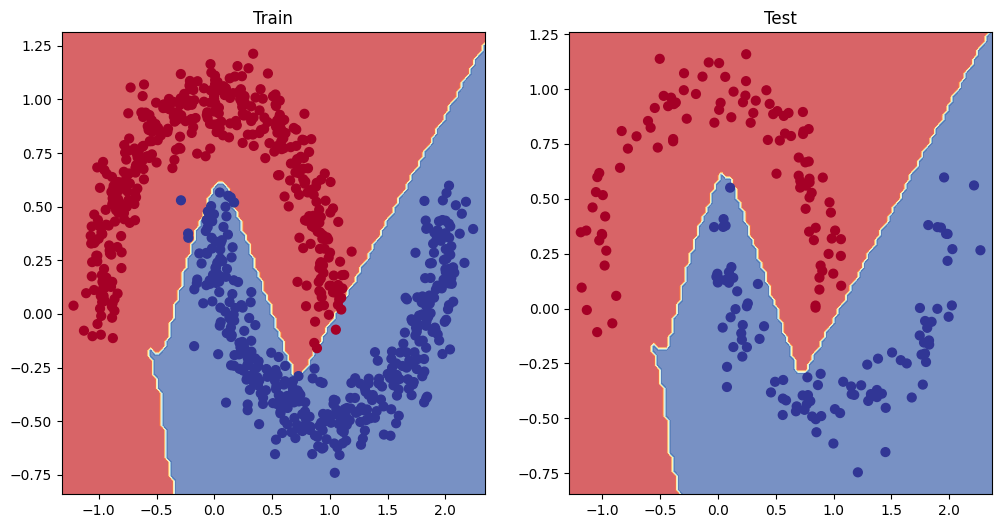

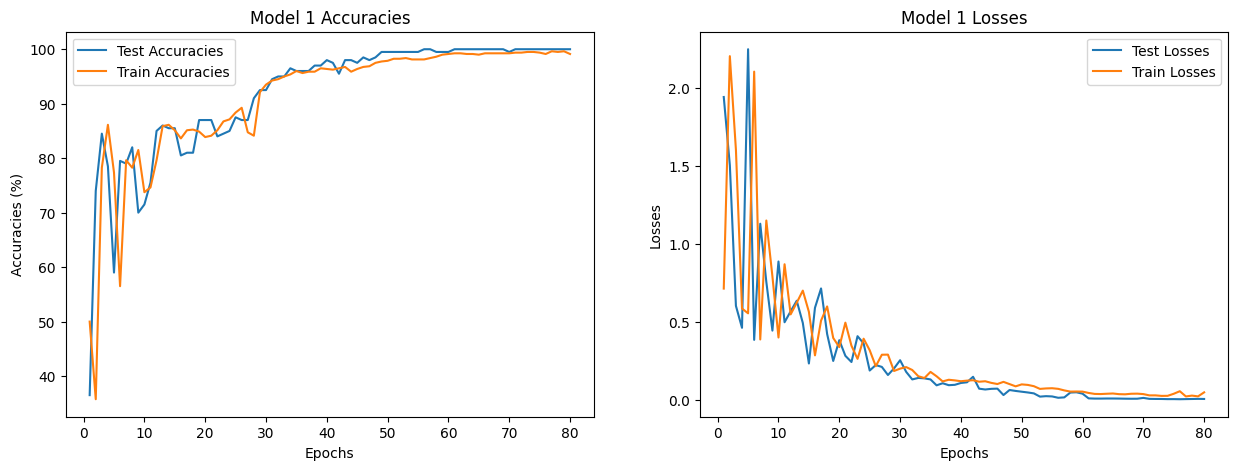

In [349]:
tr_losses_1,tr_accs_1,test_losses_1,test_accs_1=train_model(
    model=model_1,epochs=80,X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
    optimiser=torch.optim.Adam,lr=2)
visualise_predictions(model=model_1,X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
plot_acc_losses(model_name="Model 1", 
                train_accs=tr_accs_1, 
                test_accs=test_accs_1, 
                train_losses=tr_losses_1, 
                test_losses=test_losses_1, 
                epochs=80)

## Multiclass Cluster Classification

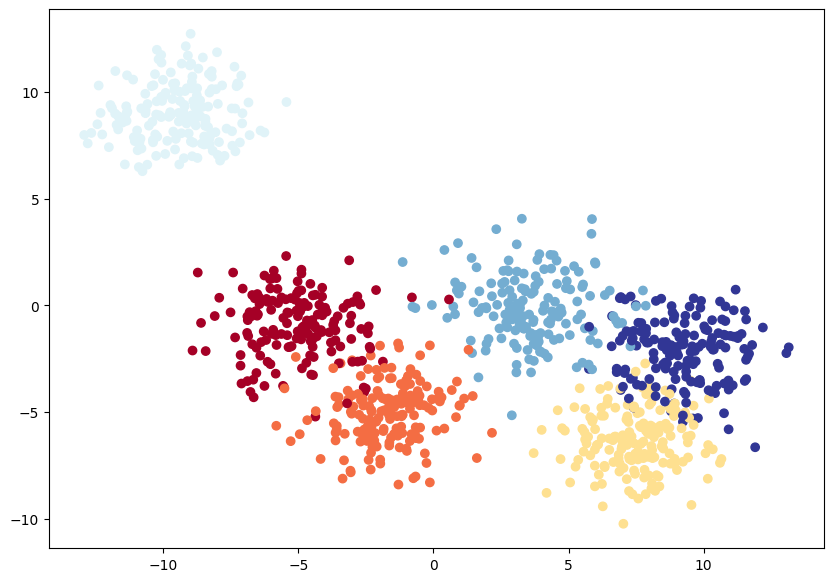

In [311]:
NUM_CLASSES=6
NUM_FEATURES=2

#create multiclass data
X_blob,y_blob=make_blobs(n_samples=1000,
                        n_features=NUM_FEATURES, #X has 2 features
                        centers=NUM_CLASSES, #y labels
                        cluster_std=1.5, #spread of clusters
                        random_state=33)

#turn data into tensors
X_blob=torch.from_numpy(X_blob).type(torch.float)
y_blob=torch.from_numpy(y_blob).type(torch.LongTensor)

#split into train and test sets
X_blob_train,X_blob_test,y_blob_train,y_blob_test=train_test_split(
    X_blob,
    y_blob,
    test_size=0.2,
    random_state=13)

X_blob_train, X_blob_test = X_blob_train.to(device), X_blob_test.to(device)
y_blob_train, y_blob_test = y_blob_train.to(device), y_blob_test.to(device)

#plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob,cmap=plt.cm.RdYlBu)

In [312]:
class BlobModel(nn.Module):
    def __init__(self, input_features,output_features,hidden_units=10):
        """initialises all required hyperparameters for a multi-class classification model

        args:
            input_features (int): num of input features to the model
            out_features (int): num of output features of the model = num of classes
            hidden_units (int): num of hidden units between layers, default 8
        """
        super().__init__()
        self.linear_layer_stack=nn.Sequential(
            nn.Linear(in_features=input_features,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_features)
        )
    def forward(self,x):
        return self.linear_layer_stack(x)

In [319]:
blob_0=BlobModel(input_features=NUM_FEATURES,
                 output_features=NUM_CLASSES,
                 hidden_units=8).to(device)

Epoch: 0 | Train Loss: 1.81973, Train Accuracy: 16.50% | Test loss: 1.64016, Test acc: 28.50%
Epoch: 30 | Train Loss: 0.56429, Train Accuracy: 80.38% | Test loss: 0.53025, Test acc: 82.00%
Epoch: 60 | Train Loss: 0.33732, Train Accuracy: 89.12% | Test loss: 0.31468, Test acc: 90.00%
Epoch: 90 | Train Loss: 0.27826, Train Accuracy: 91.50% | Test loss: 0.25707, Test acc: 91.00%
Epoch: 120 | Train Loss: 0.24406, Train Accuracy: 92.62% | Test loss: 0.22645, Test acc: 92.50%
Epoch: 150 | Train Loss: 0.21879, Train Accuracy: 92.75% | Test loss: 0.20547, Test acc: 94.00%
Epoch: 180 | Train Loss: 0.19883, Train Accuracy: 93.50% | Test loss: 0.18989, Test acc: 94.00%
Epoch: 210 | Train Loss: 0.18798, Train Accuracy: 93.12% | Test loss: 0.17924, Test acc: 94.00%
Epoch: 240 | Train Loss: 0.17957, Train Accuracy: 93.88% | Test loss: 0.17131, Test acc: 94.00%
Epoch: 270 | Train Loss: 0.17180, Train Accuracy: 93.88% | Test loss: 0.16390, Test acc: 95.00%


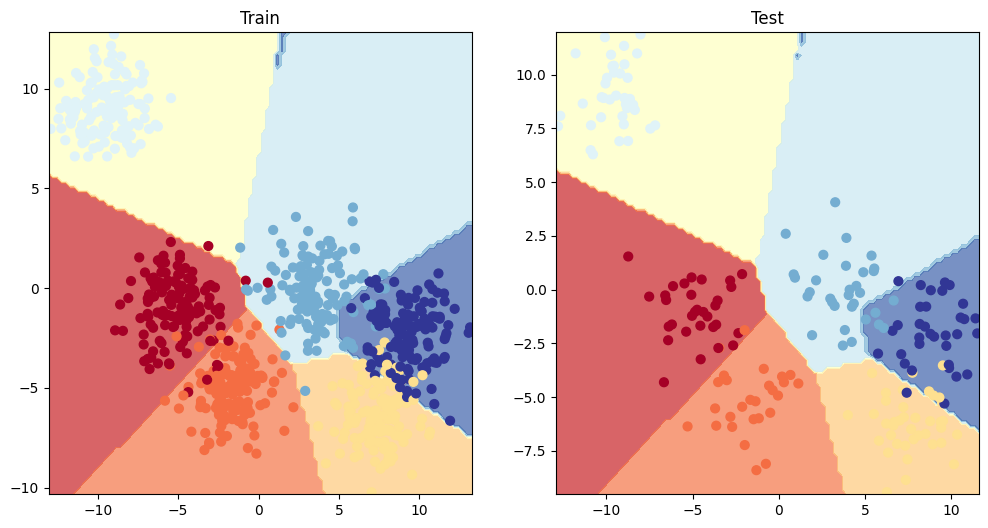

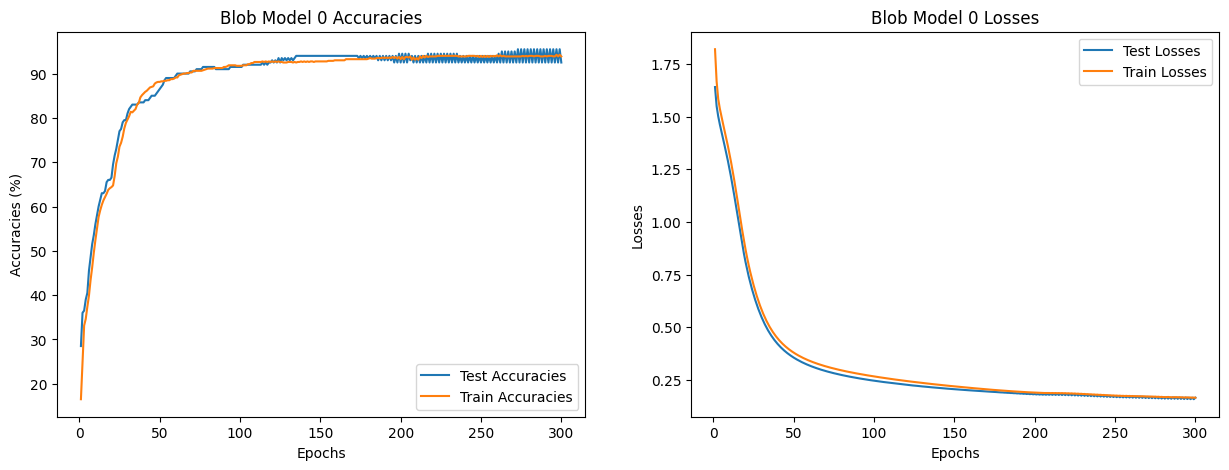

In [320]:
(tr_losses_blob_0,tr_accs_blob_0,
 test_losses_blob_0,test_accs_blob_0)=train_model(
     model=blob_0,
     epochs=300,
     X_train=X_blob_train,
     y_train=y_blob_train,
     X_test=X_blob_test,
     y_test=y_blob_test)

visualise_predictions(model=blob_0,
                      X_train=X_blob_train,
                      X_test=X_blob_test,
                      y_train=y_blob_train,
                      y_test=y_blob_test)
plot_acc_losses(model_name="Blob Model 0", 
                train_accs=tr_accs_blob_0, 
                test_accs=test_accs_blob_0, 
                train_losses=tr_losses_blob_0, 
                test_losses=test_losses_blob_0, 
                epochs=300)